# Experiment: Varying N in top-N DDA fragmentation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import sys
from collections import defaultdict
import seaborn as sns

In [3]:
sys.path.append('../codes')

In [4]:
from VMSfunctions.Chemicals import *
from VMSfunctions.Chromatograms import *
from VMSfunctions.MassSpec import *
from VMSfunctions.Controller import *
from VMSfunctions.Common import *
from VMSfunctions.DataGenerator import *
from VMSfunctions.Noise import *

### Useful functions

Performance is calculated by precision, recall and the mean square error of intensity when the fragmentation event occur to the maximum intensity of the chromatographic peak.

In [5]:
def get_key(chem):
    # turn a chem into (mz, rt, intensity) for equal comparison
    return (tuple(chem.isotopes), chem.rt, chem.max_intensity)

def get_frag_events(controller, ms_level):
    # get the fragmentation events for all chemicals for an ms level
    filtered_frag_events = list(filter(lambda x: x.ms_level == ms_level, controller.mass_spec.fragmentation_events))
    chem_to_frag_events = defaultdict(list)
    for frag_event in filtered_frag_events:
        key = get_key(frag_event.chem)
        chem_to_frag_events[key].append(frag_event)
    return dict(chem_to_frag_events)

def count_frag_events(key, chem_to_frag_events):
    # count how many good and bad fragmentation events for each chemical (key)
    frag_events = chem_to_frag_events[key]
    good_count = 0
    bad_count = 0
    for frag_event in frag_events:
        chem = frag_event.chem
        rt_match = chem.chromatogram._rt_match(frag_event.query_rt - chem.rt)
        if rt_match:
            good_count += 1
        else:
            bad_count += 1
    return good_count, bad_count

def get_chem_frag_counts(chem_list, chem_to_frag_events):
    # get the count of good/bad fragmentation events for all chemicals in chem_list
    results = {}
    for i in range(len(chem_list)):
        chem = chem_list[i]
        key = get_key(chem)
        try:
            good_count, bad_count = count_frag_events(key, chem_to_frag_events)
        except KeyError:
            good_count = 0
            bad_count = 0
        results[chem] = {
            'good': good_count, 
            'bad': bad_count
        }
    return results

In [6]:
def compute_performance(controller, dataset):
    ms_level = 2
    chem_to_frag_events = get_frag_events(controller, ms_level)
    positives = list(filter(lambda x: x.type == 'data', dataset))
    negatives = list(filter(lambda x: x.type == 'noise', dataset))
    positives_count = get_chem_frag_counts(positives, chem_to_frag_events)
    negatives_count = get_chem_frag_counts(negatives, chem_to_frag_events)    

    # count the following:
    # true positive = is an xcms peak (positive) and is fragmented within the chemical's elution time
    # false positive = is not an xcms peak (negative) and is fragmented within the chemical's elution time
    # false negative = is an xcms peak (positive) and is not fragmented within the chemical's elution time
    tp = len([chem for chem in positives if positives_count[chem]['good'] > 0])
    fp = len([chem for chem in negatives if negatives_count[chem]['good'] > 0])
    fn = len([chem for chem in positives if positives_count[chem]['good'] == 0])

    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f1 = ( 2 * prec * rec) / (prec + rec)
    prec, rec, f1
    return tp, fp, fn, prec, rec, f1

In [7]:
def load_controller(results_dir, N, rt_tol):
    analysis_name = 'experiment_N_%d_rttol_%d' % (N, rt_tol)    
    pickle_in = '%s/%s.p' % (results_dir, analysis_name) 
    print('Loading %s' % analysis_name)                    
    try:
        controller = load_obj(pickle_in)
    except FileNotFoundError:
        controller = None
    return controller

def load_controllers(results_dir, Ns, rt_tols):
    controllers = []
    for N in Ns:
        for rt_tol in rt_tols:
            controller = load_controller(results_dir, N, rt_tol)
            if controller is not None:
                controllers.append(controller)
    return controllers

### Load experiment results

In [8]:
results_dir = '../models/dda_results'

In [9]:
dataset = load_obj('%s/noisy_dataset.p' % results_dir)

### Compute performance

In [10]:
%matplotlib inline

#### Fixed rt_tol = 15 and varying Ns

In [11]:
Ns = [1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
rt_tols = [15]

In [12]:
results = []
for N in Ns:
    for rt_tol in rt_tols:
        controller = load_controller(results_dir, N, rt_tol)
        if controller is not None:
            tp, fp, fn, prec, rec, f1 = compute_performance(controller, dataset)      
            print('N=%d rt_tol=%d tp=%d fp=%d fn=%d prec=%.3f rec=%.3f f1=%.3f' % (N, rt_tol, tp, fp, fn, prec, rec, f1))
            res = (N, rt_tol, tp, fp, fn, prec, rec, f1)    
            results.append(res)            

Loading experiment_N_1_rttol_15
N=1 rt_tol=15 tp=4366 fp=3363 fn=5462 prec=0.565 rec=0.444 f1=0.497
Loading experiment_N_2_rttol_15
N=2 rt_tol=15 tp=4652 fp=3630 fn=5176 prec=0.562 rec=0.473 f1=0.514
Loading experiment_N_3_rttol_15
N=3 rt_tol=15 tp=4782 fp=3690 fn=5046 prec=0.564 rec=0.487 f1=0.523
Loading experiment_N_5_rttol_15
N=5 rt_tol=15 tp=4926 fp=3855 fn=4902 prec=0.561 rec=0.501 f1=0.529
Loading experiment_N_10_rttol_15
N=10 rt_tol=15 tp=5118 fp=3996 fn=4710 prec=0.562 rec=0.521 f1=0.540
Loading experiment_N_15_rttol_15
N=15 rt_tol=15 tp=5188 fp=4050 fn=4640 prec=0.562 rec=0.528 f1=0.544
Loading experiment_N_20_rttol_15
N=20 rt_tol=15 tp=5188 fp=4057 fn=4640 prec=0.561 rec=0.528 f1=0.544
Loading experiment_N_25_rttol_15
N=25 rt_tol=15 tp=5193 fp=4090 fn=4635 prec=0.559 rec=0.528 f1=0.543
Loading experiment_N_30_rttol_15
N=30 rt_tol=15 tp=5191 fp=4111 fn=4637 prec=0.558 rec=0.528 f1=0.543
Loading experiment_N_35_rttol_15
N=35 rt_tol=15 tp=5186 fp=4088 fn=4642 prec=0.559 rec=0.5

In [ ]:
df = pd.DataFrame(results, columns=['N', 'rt_tol', 'TP', 'FP', 'FN', 'Prec', 'Rec', 'F1'])

In [16]:
def make_plot(df, X, Y, title, ylabel):
    df.plot.line(x=X, y=Y)
    plt.title(title)
    plt.ylabel(ylabel)

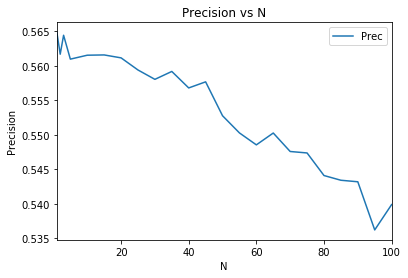

In [17]:
make_plot(df, 'N', ['Prec'], 'Precision vs N', 'Precision')

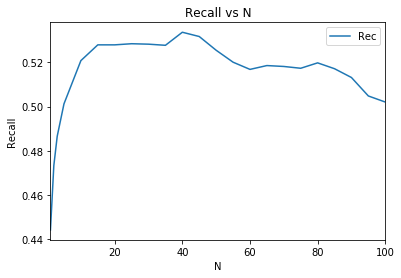

In [19]:
make_plot(df, 'N', ['Rec'], 'Recall vs N', 'Recall')

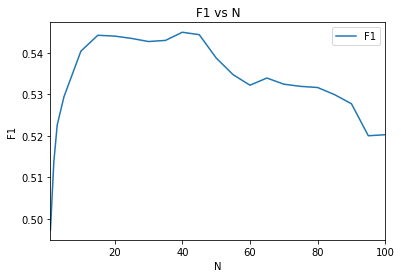

In [20]:
make_plot(df, 'N', ['F1'], 'F1 vs N', 'F1')

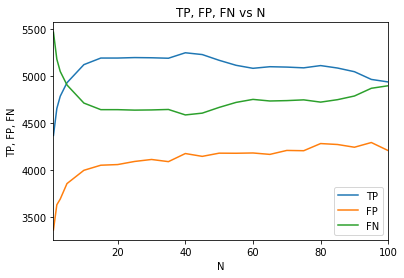

In [22]:
make_plot(df, 'N', ['TP', 'FP', 'FN'], 'TP, FP, FN vs N', 'TP, FP, FN')

In [23]:
df

,N,rt_tol,TP,FP,FN,Prec,Rec,F1
0,1,15,4366,3363,5462,0.564885,0.444241,0.497351
1,2,15,4652,3630,5176,0.561700,0.473341,0.513749
2,3,15,4782,3690,5046,0.564448,0.486569,0.522623
3,5,15,4926,3855,4902,0.560984,0.501221,0.529421
4,10,15,5118,3996,4710,0.561554,0.520757,0.540386
5,15,15,5188,4050,4640,0.561593,0.527880,0.544215
6,20,15,5188,4057,4640,0.561168,0.527880,0.544015
7,25,15,5193,4090,4635,0.559410,0.528388,0.543457
8,30,15,5191,4111,4637,0.558052,0.528185,0.542708
9,35,15,5186,4088,4642,0.559198,0.527676,0.542980


#### Fixed N = 10 and varying rt_tols

In [ ]:
Ns = [10]
rt_tols = list(range(15, 301, 15))
controllers = load_controllers(results_dir, Ns, rt_tols)

In [ ]:
results = []
for controller in controllers:
    N = controller.N
    rt_tol = controller.rt_tol
    tp, fp, fn, prec, rec, f1 = compute_performance(controller, dataset)      
    print('N=%d rt_tol=%d tp=%d fp=%d fn=%d prec=%.3f rec=%.3f f1=%.3f' % (N, rt_tol, tp, fp, fn, prec, rec, f1))
    res = (N, rt_tol, tp, fp, fn, prec, rec, f1)    
    results.append(res)

In [ ]:
df = pd.DataFrame(results, columns=['N', 'rt_tol', 'TP', 'FP', 'FN', 'Prec', 'Rec', 'F1'])
df.plot.line(x='N', y=['Prec'])
plt.title('Precision vs N')
plt.ylabel('Precision')

df.plot.line(x='N', y=['Rec'])
plt.title('Recall vs N')
plt.ylabel('Recall')

df.plot.line(x='N', y=['F1'])
plt.title('F1 vs N')
plt.ylabel('F1')

In [ ]:
df

### Compute performance for varying Ns and rt_tols

In [ ]:
Ns = [1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
rt_tols = list(range(15, 301, 15))

In [ ]:
X, Y = np.meshgrid(Ns, rt_tols)
Z_precision = np.zeros_like(X).astype(float)
Z_recall = np.zeros_like(X).astype(float)
Z_f1 = np.zeros_like(X).astype(float)

In [ ]:
for j in range(X.shape[1]):
    for i in range(X.shape[0]):    
        N = X[i, j]
        rt_tol = Y[i, j]            
        analysis_name = 'experiment_N_%d_rttol_%d' % (N, rt_tol)    
        pickle_in = '%s/%s.p' % (results_dir, analysis_name) 

        print('Loading %s' % analysis_name)                    
        try:
            controller = load_obj(pickle_in)
        except FileNotFoundError:
            controller = None

        # compute performance
        if controller is not None:
            tp, fp, fn, prec, rec, f1 = compute_performance(controller, dataset)
            Z_precision[i, j] = prec
            Z_recall[i, j] = rec
            Z_f1[i, j] = f1

### Make plot

In [ ]:
plot_data = {
    'X': X,
    'Y': Y,
    'Z_precision': Z_precision,
    'Z_recall': Z_recall,
    'Z_f1': Z_f1
}

In [ ]:
save_obj(plot_data, results_dir + '/plot_data.p')

In [ ]:
def make_plot(X, Y, Z, xlabel, ylabel, zlabel, title):
    # Plot the surface.
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    # Customize the z axis.
    # ax.set_zlim(-1.01, 1.01)
    # ax.zaxis.set_major_locator(LinearLocator(10))
    # ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)    
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [ ]:
%matplotlib notebook

In [ ]:
make_plot(X, Y, Z_precision, 'N', 'Dynamic exclusion window (s)', 'Precision', 'Precision with varying Ns and dynamic exclusion windows')

In [ ]:
make_plot(X, Y, Z_recall, 'N', 'Dynamic exclusion window (s)', 'Recall', 'Recall with varying Ns and dynamic exclusion windows')

In [ ]:
make_plot(X, Y, Z_f1, 'N', 'Dynamic exclusion window (s)', 'F_1', 'F_1 score with varying Ns and dynamic exclusion windows')

In [ ]:
%matplotlib inline

In [ ]:
make_plot(X, Y, Z_precision, 'N', 'Dynamic exclusion window (s)', 'Precision', 'Precision with varying Ns and dynamic exclusion windows')

In [ ]:
make_plot(X, Y, Z_recall, 'N', 'Dynamic exclusion window (s)', 'Recall', 'Recall with varying Ns and dynamic exclusion windows')

In [ ]:
make_plot(X, Y, Z_f1, 'N', 'Dynamic exclusion window (s)', 'F_1', 'F_1 score with varying Ns and dynamic exclusion windows')